In [1]:
import torch
from PIL import Image
import numpy as np
import os
from gatys import Gatys
from numba import njit
from numba.typed import List
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
# dataset_dir = r"D:\datasets\test2017"

# files_list = []

# for file in os.listdir(dataset_dir):
#     tmp = os.path.join(dataset_dir, file)
#     if os.path.isfile(tmp):
#         files_list.append(tmp)

In [3]:
# indices = np.random.choice(np.arange(0, len(files_list)), size=1000, replace=False)
# saved_file_paths = [files_list[i] for i in indices]

# saved_txt_path = "saved_images_path.txt"
# with open(saved_txt_path, "w") as f:
#     for saved_path in saved_file_paths:
#         f.write(saved_path)
#         f.write("\n")

In [2]:
# load already saved images_path
saved_txt_path = "saved_images_path.txt"
saved_file_paths = []
with open(saved_txt_path, "r") as file:
    for text in file.readlines():
        saved_file_paths.append(text.rstrip())

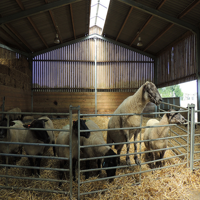

In [3]:
# load and show the first image
img = Image.open(saved_file_paths[0])
img.resize((200, 200)).convert("RGB")

In [4]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# let's start with AdaIN method
gatys_method = Gatys(pool='avg').to(device)

In [6]:
# precompute all the content information for each image
content_information = []

for i in range(len(saved_file_paths)):
    img = Image.open(saved_file_paths[i])
    content_info = gatys_method.get_content_from_image(img, pil=True)
    
    content_information.append([v.detach().cpu().clone() for v in content_info])
    img.close()

In [7]:
# now let's find the closest images based on content

def find_closest_image(img_ind, info):
    min_ind = 0
    min_value = np.inf
    for i in range(len(info)):
        tmp = 0
        for j in range(len(info[i])):
            tmp += torch.sum((info[i][j] - info[img_ind][j])**2)
        if tmp < min_value and i!=img_ind:
            min_ind = i
            min_value = tmp
    return min_ind

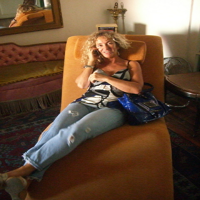

In [11]:
img_ind = 94
img = Image.open(saved_file_paths[img_ind])
img.resize((200, 200))

In [12]:
closest_img_ind = find_closest_image(img_ind, content_information)

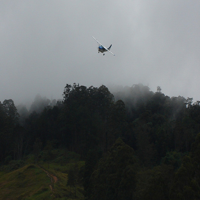

In [13]:
closest_img = Image.open(saved_file_paths[closest_img_ind])
closest_img.resize((200, 200))

### now for style search

In [14]:
# precompute all the style information for each image
style_information = []

for i in range(len(saved_file_paths)):
    img = Image.open(saved_file_paths[i])
    style_info = gatys_method.get_style_from_image(img, pil=True)
    
    style_information.append([v.detach().cpu().clone() for v in style_info])
    img.close()

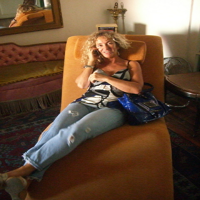

In [15]:
img_ind = 94
img = Image.open(saved_file_paths[img_ind])
img.resize((200, 200))

In [16]:
closest_img_ind = find_closest_image(img_ind, style_information)

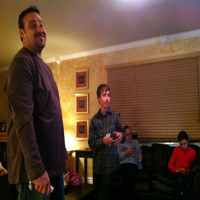

In [17]:
closest_img = Image.open(saved_file_paths[closest_img_ind])
closest_img.resize((200, 200))

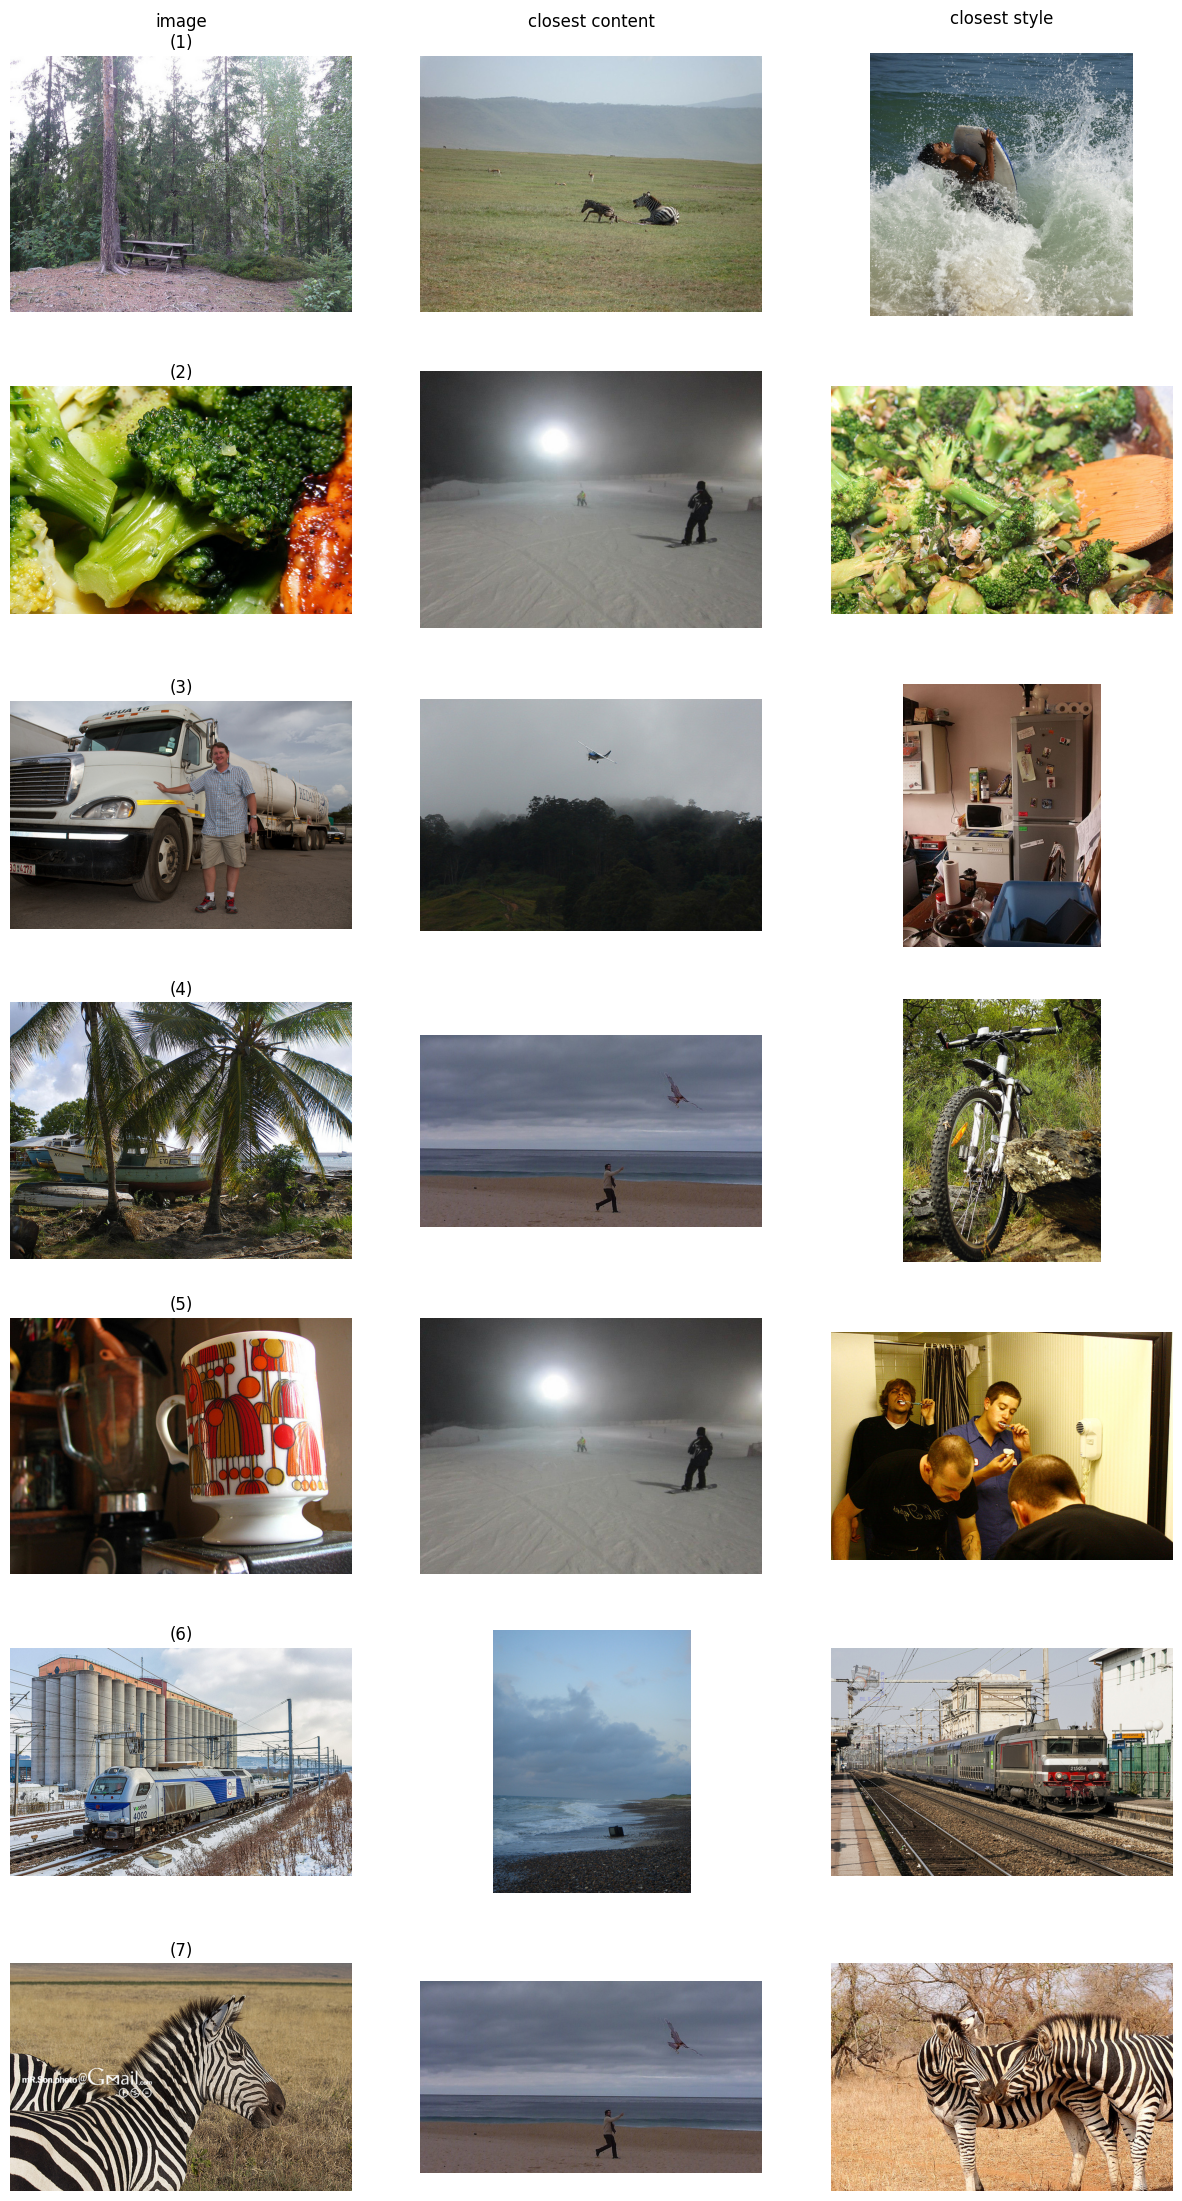

In [18]:
indices = [1, 2, 4, 6, 7, 98, 9]

fig, ax = plt.subplots(len(indices), 3)
fig.set_figwidth(15)
fig.set_figheight(4*len(indices))

for i, ind in enumerate(indices):
    img = Image.open(saved_file_paths[ind])
    closest_content_ind = find_closest_image(ind, content_information)
    closest_style_ind = find_closest_image(ind, style_information)

    ax[i, 0].imshow(img)
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f"({i+1})")
    ax[i, 1].imshow(Image.open(saved_file_paths[closest_content_ind]))
    ax[i, 1].axis('off')
    ax[i, 2].imshow(Image.open(saved_file_paths[closest_style_ind]))
    ax[i, 2].axis('off')


ax[0, 0].set_title("image\n(1)")
ax[0, 1].set_title("closest content\n")
ax[0, 2].set_title("closest style\n")
plt.show()